In [1]:
from importing import *
from TravelAndMutate.randominterface import NumpyRandomGenerator
from TravelAndMutate.system import System

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sb
from time import time
from scipy.optimize import root_scalar

In [3]:
seed = np.prod([ord(c) for c in "TravelAndMutate"]).astype("uint32")
rng = NumpyRandomGenerator(seed)

In [4]:
def kernel(rng, tmax, params, commuting_mat):
    sys = System(rng.cpprng, 1, commuting_mat, params.to_records(index=False))
    sys.spreadForTime(tmax)
    return [pd.DataFrame.from_records(sys.getFullTrajectory(p), index="t") / params["N"][p] for p in range(params.shape[0])]

In [5]:
start = time()

Npatch = 2
tmax = 100000
reps = 100
c_ijs = np.linspace(0,1,11)
betas = np.linspace(0.04,0.15,23)

results = []

for j,c_ij in enumerate(c_ijs):
	for k,beta in enumerate(betas):
		for i in range(reps):
			
			commuting = np.diag(np.full(Npatch, 1))
			commuting = commuting + np.diag(np.full(Npatch-1, c_ij), -1)
			commuting = commuting + np.diag(np.full(Npatch-1, c_ij), 1)
			commuting[(Npatch-1,0),(0,Npatch-1)] = c_ij
			
			params = pd.DataFrame()
			params["N"] = np.full(Npatch, 1e5, dtype="u4")
			params["beta"] = np.full(Npatch, beta)
			params["epsilon"] = np.full(Npatch, 0.1)
			params["mu"] = np.full(Npatch, 0.1)
			params["I0"] = np.zeros(Npatch, dtype="u4")
			params.loc[rng.rng.integers(Npatch), "I0"] = 2
			params.index.name = "Patch"

			result = kernel(rng, tmax, params, commuting)
			results.append([c_ij, beta, np.sum([r["R"].iloc[-1]/Npatch for r in result])])
		print(f"{(j*len(betas)+k)*100//(len(c_ijs)*len(betas)*reps)}%", flush=True, end="\r")

results = pd.DataFrame(results, columns=["c_ij", "beta", "R"])

end = time()
print(f"Duration per replica: {np.round((end-start)/reps/len(c_ijs)/len(betas), 2)} sec")

Duration per replica: 0.01 sec


In [6]:
results

,c_ij,beta,R
0,0.0,0.04,0.000010
1,0.0,0.04,0.000020
2,0.0,0.04,0.000010
3,0.0,0.04,0.000050
4,0.0,0.04,0.000070
...,...,...,...
25295,1.0,0.15,0.944075
25296,1.0,0.15,0.943540
25297,1.0,0.15,0.942980
25298,1.0,0.15,0.944090


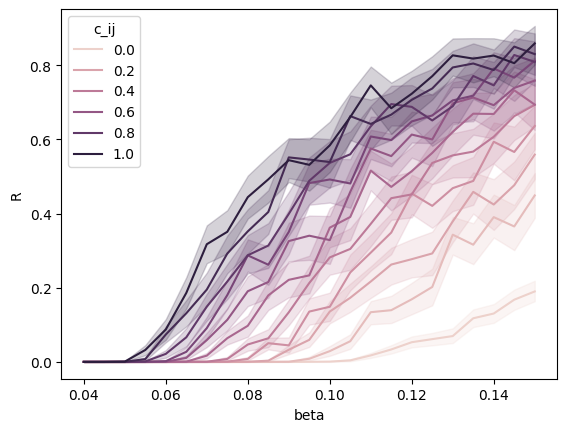

In [7]:
sb.lineplot(data=results, x="beta", y="R", hue="c_ij")
plt.savefig("../plots/phase_transition.png")